In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor, Button
from scipy import signal
import math
import os

directory  = 'data/Research_B/Data/'
AllHeartbeats = []
AllPeaks = []
count = 0

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if os.path.isfile(f):
        
        highest_peak_values = []
        highest_peak_indices = []

        data = []
        RMSSD = []

        with open(f, 'r') as file:
            data_started = False
            for line in file:
                # Check if the line contains data
                if data_started:
                    values = line.strip().split()
                    data.append([int(val) for val in values])
                elif line.strip() == "# EndOfHeader":
                    data_started = True

            # Convert the data into a NumPy array
            data = np.array(data)

            heartbeat_data = data[:, 2]

            #Toggle inverse heartbeatdata
            if False:
                heartbeat_data = -heartbeat_data

            heightthreshold = 150  # Adjust this threshold as needed
            widthtreshold = 200


            #Butterworth filter
            sos = signal.butter(2, 3, 'highpass',fs = 1000, output = 'sos')
            filtered = signal.sosfilt(sos, heartbeat_data)

            # Create an array for the x-axis (time)
            time = np.arange(len(heartbeat_data))

            peaks, _ = signal.find_peaks(filtered, height=heightthreshold, distance= widthtreshold)
            AllHeartbeats.append(heartbeat_data)
            AllPeaks.append(peaks)
            print(count, end=' ')
            count += 1


        



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 

In [4]:
#Calculate HRV with RMSSD
interval = 29000  # Meettijd per HRV waarde (ms)

All_HRV = []

def calculate_rmssd(heartbeat_data, peaks):
    HRVRMSSD = []
    waarde1 = 0
    waarde2 = interval

    for i in range(int((len(heartbeat_data) - interval) / 1000)):
        peaks_in_range_interval = [peak for peak in peaks if waarde1 <= peak <= waarde2]
        squared_differences = [(heartbeat_data[peaks[i+1]] - heartbeat_data[peaks[i]]) ** 2 for i in range(len(peaks_in_range_interval)-1)]
        mean_squared_diff = sum(squared_differences) / (len(peaks_in_range_interval) - 1)
        rmssd_value = math.sqrt(mean_squared_diff)
        HRVRMSSD.append(rmssd_value)
        waarde1 += 1000
        waarde2 += 1000

    return HRVRMSSD

# Voer de functie uit om HRVRMSSD te berekenen
count = 0
for peaks in AllPeaks:
    HRVRMSSD = calculate_rmssd(AllHeartbeats[count], peaks)
    
    # maakt een lijst binnen in de lijst
    All_HRV.append(HRVRMSSD)

    count += 1

with open('RMSSD.txt', 'w') as file:
    file.write("HRV Stress\n")  # Writing column headers

    for hrv_data in All_HRV:
        for i, value in enumerate(hrv_data):
            if (
                (180 <= i <= 330) or
                (570 <= i <= 720) or
                (960 <= i <= 1110)
            ):
                file.write(f"{value} 1\n")  # Writing 1 if within the specified ranges
            else:
                file.write(f"{value} 0\n")  # Writing 0 for other values
        file.write('\n')  # Add a newline to separate different HRV data sets


print('')
print(All_HRV[0])


[51.28403876040719, 51.28403876040719, 51.28403876040719, 51.28403876040719, 51.737904971218256, 51.737904971218256, 51.28403876040719, 51.737904971218256, 51.737904971218256, 51.737904971218256, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.871820040227185, 51.871820040227185, 51.423621895865026, 51.871820040227185, 51.871820040227185, 51.423621895865026, 51.423621895865026, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 50.989618320503126, 50.989618320503126, 51.871820040227185, 51.871820040227185, 51.871820040227185, 50.989618320503126, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.423621895865026, 51.423621895865026, 51.871820040227185, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.871820040227185, 51.423621895865026, 51.

In [ ]:
#Calculate HRV with SDNN

All_HRV3 = []
def calculate_sdnn(heartbeat_data, peaks):
    waarde1 = 0
    waarde2 = interval
    peaks_in_range_interval = 0
    peaks_in_range_interval2 = len([peak for peak in peaks if waarde1 <= peak <= waarde2])

    SDNNGem = 0
    SDNN = []
    HRVSDNN = []
    SDNNV = 0

    r=0

    for i in range(int((len(heartbeat_data)-interval)/1000)):
        #Tel meetwaardes bij elkaar op en deel deze door het aantal waardes om het gemiddelde te berekenen.
        for j in range(peaks_in_range_interval, peaks_in_range_interval2):
            SDNNGem += heartbeat_data[peaks[peaks_in_range_interval]]
        SDNNGem = SDNNGem/(peaks_in_range_interval2 - peaks_in_range_interval)

        #Bereken de afwijking per meetwaarde ten opzichte van het gemiddelde en neem hier het kwadraat van
        for g in range(peaks_in_range_interval, peaks_in_range_interval2):
            SDNN.append(math.pow(heartbeat_data[peaks[peaks_in_range_interval+r]] - SDNNGem, 2)) #heartbeat_data vervangen door pieken
            r = r+1

        #Tel de gekwadrateerde afwijkingen bij elkaar op en deel deze door het aantal meet meetwaardes, en neem hier vervolgens de wortel van
        SDNNV = sum(SDNN)
        HRVSDNN.append(math.sqrt(SDNNV/len(SDNN)))

        #Reset variabelen
        r = 0
        SDNNGem = 0
        SDNNV = 0
        SDNN = []

        #Verschuif het window met 1 seconden (1000 ms)
        waarde1 = waarde1 + 1000
        waarde2 = waarde2 + 1000
        peaks_in_range_interval = len([peak for peak in peaks if 0 <= peak <= waarde1])
        peaks_in_range_interval2 = len([peak for peak in peaks if 0 <= peak <= waarde2])
    return HRVSDNN

count = 0
for peaks in AllPeaks:
    HRVSDNN = calculate_sdnn((AllHeartbeats[count]), peaks)
    All_HRV3.append(HRVSDNN)
    print(count, end=' ')
    count += 1



with open('SDNN.txt', 'w') as file:
    file.write("HRV Stress Base Stilte Muziek TempoMuziek\n")  # Writing column headers
    counter = 0
    for hrv_data in All_HRV:
        for i, value in enumerate(hrv_data):
            if (
                (180 <= i <= 330) or
                (570 <= i <= 720) or
                (960 <= i <= 1110)
            ):
                file.write(f"{value} 1 ")  # Writing 1 if within the specified ranges HRV
            else:
                file.write(f"{value} 0 ")  # Writing 0 for other values HRV
def A():
    if i < 180:
        file.write(f'1 0 0 0\n')# Writing 1 for 'Baseline'column
    elif 330 <= i <= 570:
        file.write(f"0 1 0 0\n")  # Writing 1 for 'Stilte' column
    elif 720 <= i <= 960:
        file.write(f"0 0 1 0\n")  # Writing 1 for 'Muziek' column
    elif 1110 <= i <= 1350:
        file.write(f"0 0 0 1\n")  # Writing 1 for 'Tempo_Verlagende_Muziek' column
    else:
        file.write(f"0 0 0 0\n")  # Writing 0 for all other columns
    file.write('\n')  # Add a newline to separate different HRV data sets

def B():
    if i < 180:
        file.write(f'1 0 0 0\n')# Writing 1 for 'Baseline'column
    elif 330 <= i <= 570:
        file.write(f"0 1 0 0\n")  # Writing 1 for 'Stilte' column
    elif 720 <= i <= 960:
        file.write(f"0 0 0 1\n")  # Writing 1 for 'Muziek' column
    elif 1110 <= i <= 1350:
        file.write(f"0 0 1 0\n")  # Writing 1 for 'Tempo_Verlagende_Muziek' column
    else:
        file.write(f"0 0 0 0\n")  # Writing 0 for all other columns
    file.write('\n')  # Add a newline to separate different HRV data sets

def C():
    if i < 180:
        file.write(f'1 0 0 0\n')# Writing 1 for 'Baseline'column
    elif 330 <= i <= 570:
        file.write(f"0 0 1 0\n")  # Writing 1 for 'Stilte' column
    elif 720 <= i <= 960:
        file.write(f"0 1 0 0\n")  # Writing 1 for 'Muziek' column
    elif 1110 <= i <= 1350:
        file.write(f"0 0 0 1\n")  # Writing 1 for 'Tempo_Verlagende_Muziek' column
    else:
        file.write(f"0 0 0 0\n")  # Writing 0 for all other columns
    file.write('\n')  # Add a newline to separate different HRV data sets

def D():
    if i < 180:
        file.write(f'1 0 0 0\n')# Writing 1 for 'Baseline'column
    elif 330 <= i <= 570:
        file.write(f"0 0 1 0\n")  # Writing 1 for 'Stilte' column
    elif 720 <= i <= 960:
        file.write(f"0 0 0 1\n")  # Writing 1 for 'Muziek' column
    elif 1110 <= i <= 1350:
        file.write(f"0 1 0 0\n")  # Writing 1 for 'Tempo_Verlagende_Muziek' column
    else:
        file.write(f"0 0 0 0\n")  # Writing 0 for all other columns
    file.write('\n')  # Add a newline to separate different HRV data sets

def E():
    if i < 180:
        file.write(f'1 0 0 0\n')# Writing 1 for 'Baseline'column
    elif 330 <= i <= 570:
        file.write(f"0 0 0 1\n")  # Writing 1 for 'Stilte' column
    elif 720 <= i <= 960:
        file.write(f"0 1 0 0\n")  # Writing 1 for 'Muziek' column
    elif 1110 <= i <= 1350:
        file.write(f"0 0 1 0\n")  # Writing 1 for 'Tempo_Verlagende_Muziek' column
    else:
        file.write(f"0 0 0 0\n")  # Writing 0 for all other columns
    file.write('\n')  # Add a newline to separate different HRV data sets

def F():
    if i < 180:
        file.write(f'1 0 0 0\n')# Writing 1 for 'Baseline'column
    elif 330 <= i <= 570:
        file.write(f"0 0 0 1\n")  # Writing 1 for 'Stilte' column
    elif 720 <= i <= 960:
        file.write(f"0 0 1 0\n")  # Writing 1 for 'Muziek' column
    elif 1110 <= i <= 1350:
        file.write(f"0 1 0 0\n")  # Writing 1 for 'Tempo_Verlagende_Muziek' column
    else:
        file.write(f"0 0 0 0\n")  # Writing 0 for all other columns
    file.write('\n')  # Add a newline to separate different HRV data sets


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 

Epoch 1/200
293/293 [==============================] - 2s 2ms/step - loss: 0.2178 - val_loss: 0.2139
Epoch 2/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2139
Epoch 3/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2139
Epoch 4/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2139
Epoch 5/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2141
Epoch 6/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2141
Epoch 7/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2138
Epoch 8/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2141
Epoch 9/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2149 - val_loss: 0.2138
Epoch 10/200
293/293 [==============================] - 0s 2ms/step - loss: 0.2150 - val_lo

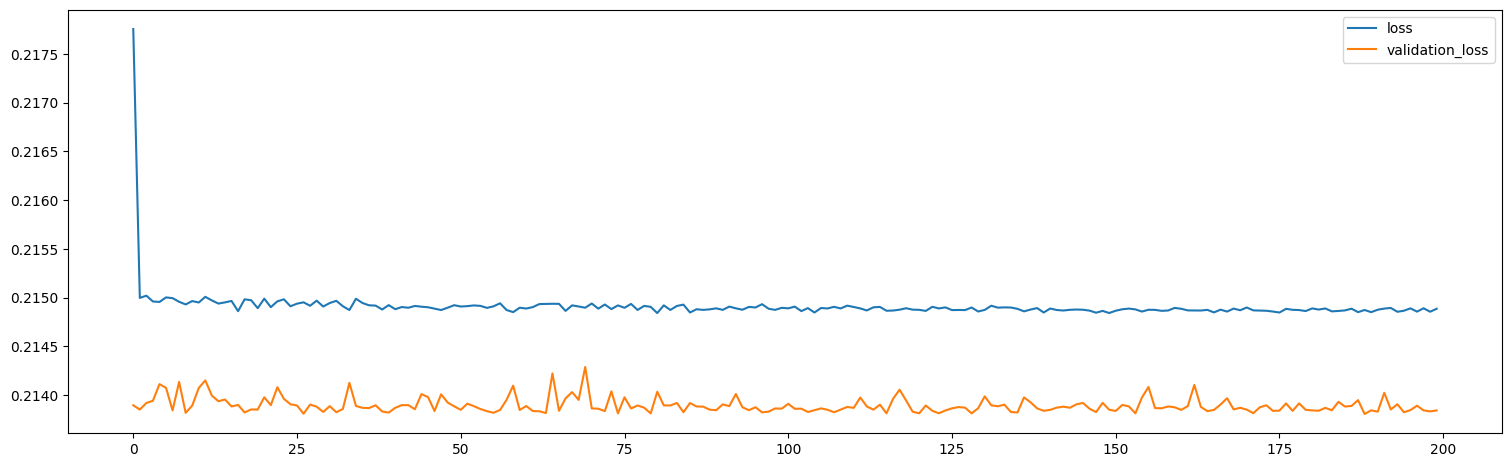

In [1]:
#Algorithm

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.metrics import r2_score

tf.get_logger().setLevel('ERROR')

# Load and process data
data = pd.read_csv('SDNN.txt', sep=' ')

columns = ['HRV', 'Stress']
data = data[columns]

X = data[['HRV']]
Y = data['Stress']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


# AI model
model = Sequential()
batch_size = 128
epochs = 200

model.add(LSTM(batch_size, input_shape=(1, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='mean_squared_error', metrics=[])

train_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=1)
score = model.evaluate(X_test, Y_test, batch_size=batch_size)

# Print training results
print("Loss: {:0.4f}".format(score))

# Model voorspelt waarschijnlijkheden per klasse
y_pred_prob = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred_prob > threshold).astype(int)

#print('Accuracy: {:0.3}'.format(100 * accuracy_score(Y_test, 1 * (y_pred_prob > 0.5))))
mae = mean_absolute_error(Y_test, y_pred_prob)
print('Mean Absolute Error (MAE): {:0.3f}'.format(mae))
mse = mean_squared_error(Y_test, y_pred_prob)
print('Mean Squared Error (MSE): {:0.3f}'.format(mse))
r_squared = r2_score(Y_test, y_pred_prob)
print('R² (R-squared): {:0.3f}'.format(r_squared))
accuracy = accuracy_score(Y_test, y_pred_binary)
print('Accuracy: {:0.3f}'.format(accuracy))

# Plot accuracy history
loss = train_history.history['loss']
validation_loss = train_history.history['val_loss']


fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)
loss = train_history.history['loss']
validation_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(validation_loss)
plt.legend(['loss', 'validation_loss'])
plt.show()


In [1]:
#Hyperparameter Calculation

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import shutil
import os
from sklearn.metrics import accuracy_score

tf.get_logger().setLevel('ERROR')

# Load and process data
data = pd.read_csv('SDNN.txt', sep=' ')

columns = ['HRV', 'Stress']
data = data[columns]

X = data[['HRV']]
Y = data['Stress']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

epochs = 200
batch_size = 128
if True:
    if os.path.exists('my_dir'):
        shutil.rmtree('my_dir')

def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(1, X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']), loss='mean_squared_error', metrics=[])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # You can adjust the number of trials
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning')

tuner.search(X_train, Y_train, epochs=epochs, validation_split=0.1, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model to your data
best_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=1)
score = best_model.evaluate(X_test, Y_test, batch_size=batch_size)

# Print training results
print("Loss: {:0.4f}".format(score))

# Model voorspelt waarschijnlijkheden per klasse
y_pred_prob = best_model.predict(X_test)
y_pred = best_model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

mae = mean_absolute_error(Y_test, y_pred_prob)
print('Mean Absolute Error (MAE): {:0.3f}'.format(mae))
mse = mean_squared_error(Y_test, y_pred_prob)
print('Mean Squared Error (MSE): {:0.3f}'.format(mse))
r_squared = r2_score(Y_test, y_pred_prob)
print('R² (R-squared): {:0.3f}'.format(r_squared))
accuracy = accuracy_score(Y_test, y_pred_binary)
print('Accuracy: {:0.3f}'.format(accuracy))


Trial 5 Complete [00h 04m 23s]
val_loss: 0.21380160748958588

Best val_loss So Far: 0.21372322738170624
Total elapsed time: 00h 24m 58s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
64                |32                |units
adam              |rmsprop           |optimizer

Epoch 1/200
1172/1172 [==============================] - 2s 1ms/step - loss: 0.2170 - val_loss: 0.2138
Epoch 2/200
1172/1172 [==============================] - 1s 1ms/step - loss: 0.2149 - val_loss: 0.2139
Epoch 3/200
1172/1172 [==============================] - 1s 996us/step - loss: 0.2149 - val_loss: 0.2140
Epoch 4/200
1172/1172 [==============================] - 1s 1000us/step - loss: 0.2150 - val_loss: 0.2139
Epoch 5/200
1172/1172 [==============================] - 1s 995us/step - loss: 0.2150 - val_loss: 0.2142
Epoch 6/200
1172/1172 [==============================] - 1s 1ms/step - loss: 0.2150 - val_loss: 0.2138
Epoch 7/200
1172/1172 [==============================] - 1s 994us/